In [1]:
%config IPCompleter.greedy = True
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
%load_ext tensorboard

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf
from datetime import datetime

pd.set_option('mode.chained_assignment', None)
sn.set(rc={'figure.figsize':(9,9)})
sn.set(font_scale=1.4)

# make results reproducible
seed = 0
np.random.seed(seed)

!rm -rf ./logs/ 

# Convolutional Neural Networks (CNNs or ConvNets)

Convolutional Neural Networks ([CNNs](https://cs231n.github.io/convolutional-networks/)), are class of deep neural networks that is most commonly applied to analyzing visual imagery. They are also known as shift invariant or space invariant artificial neural networks (SIANN), based on their shared-weights architecture and translation invariance characteristics. They have applications in image and video recognition, recommender systems, image classification, medical image analysis, natural language processing, and financial time series.

CNNs are regularized versions of multilayer perceptrons. Multilayer perceptrons usually mean fully connected networks, that is, each neuron in one layer is connected to all neurons in the next layer. The "fully-connectedness" of these networks makes them prone to overfitting data. Typical ways of regularization include adding some form of magnitude measurement of weights to the loss function. CNNs take a different approach towards regularization: they take advantage of the hierarchical pattern in data and assemble more complex patterns using smaller and simpler patterns. Therefore, on the scale of connectedness and complexity, CNNs are on the lower extreme.

Convolutional networks were inspired by biological processes in that the connectivity pattern between neurons resembles the organization of the animal visual cortex. Individual cortical neurons respond to stimuli only in a restricted region of the visual field known as the receptive field. The receptive fields of different neurons partially overlap such that they cover the entire visual field.

CNNs use relatively little pre-processing compared to other image classification algorithms. This means that the network learns the filters that in traditional algorithms were hand-engineered. This independence from prior knowledge and human effort in feature design is a major advantage.

The name “convolutional neural network” indicates that the network employs a mathematical operation called convolution. Convolution is a specialized kind of linear operation. Convolutional networks are simply neural networks that use convolution in place of general matrix multiplication in at least one of their layers.

# Architecture Overview

A convolutional neural network consists of an input and an output layer, as well as multiple hidden layers. The hidden layers of a CNN typically consist of a series of convolutional layers that convolve with a multiplication or other dot product. The activation function is commonly a RELU layer, and is subsequently followed by additional convolutions such as pooling layers, fully connected layers and normalization layers, referred to as hidden layers because their inputs and outputs are masked by the activation function and final convolution.

Though the layers are colloquially referred to as convolutions, this is only by convention. Mathematically, it is technically a sliding dot product or cross-correlation. This has significance for the indices in the matrix, in that it affects how the weight is determined at a specific index point.

Images for example in *CIFAR-10*, are tensors of size $32 \times 32 \times 3$ ($32$ wide, $32$ high and $3$ colour channels). ConvNets take advantage of the $3$ dimensional input nature of images, and have $3D$ volumes of neurons, with *width*, *height* and *depth* (*depth* here is the third dimension of an activation volume).

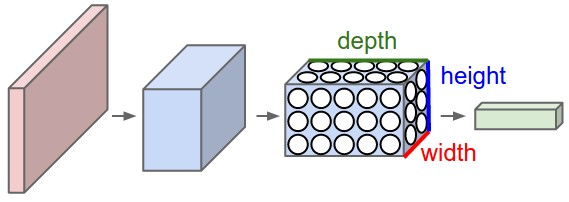
[[1](https://cs231n.github.io/convolutional-networks/)]

> A ConvNet works with $3D$ volumes of neurons in each layer, and thus each layer transforms an $3D$ input tensor to a $3D$ output volume of neuron activations. Here the red layer contains the image, with width, height and depth (here $3$ with red, green and blue channels).

In the past, traditional multilayer perceptron (MLP) models have been used for image recognition. However, due to the full connectivity between nodes, they suffered from the *curse of dimensionality*, and did not scale well with higher resolution images. A $1000 \times 1000$-pixel image with RGB color channels has 3 million weights, which is too high to feasibly process efficiently at scale with full connectivity. Such a network does not take into account the spatial structure of the data, treating input pixels which are far apart in the same way as pixels that are close together. This ignores *locality of reference* in image data, both computationally and semantically. Thus, full connectivity of neurons is wasteful for purposes such as image recognition that are dominated by spatially local input patterns. We solve this by using the ConvNet model, which specifically has a convolutional layer, which convolves the input with filter of the size of the receptive field, e.g. regardless of image size, if we used tiling regions of size $5 \times 5$, each with the same shared weights, requires only 25 learnable parameters. In this way it allows us to reduce the number of parameters (by sharing the parameters across the entire visual field), allowing a deeper network with fewer parameters.

We use three main architectures to build ConvNet architectures:
* Convolutional Layer : Computes the output of neurons that are connected to local regions in the input, each computing a dot product between their weights and a small region they are connected to in the input volume. This may result in volume such as $32 \times 32 \times 12$ if we decided to use $12$ filters.
* Pooling Layer : Performs a downsampling operation along the spatial dimensions (width, height), resulting in volume such as $16 \times 16 \times 12$.
* Fully-Connected Layer : Used to compute the class scores, resulting in volume of size $1 \times 1 \times 10$, where each of the $10$ numbers correspond to a class score, such as among the $10$ categories of CIFAR-10 

## Convolutional Layer

The Convolutional layers parameters are a set of learnable filters, each filter is usually small in equal width and height and has the same depth of the input volume. During a forward pass we convolve (slide) each filter across the width and height of the input volume and compute dot products between the entries of the filter and input at any position. Each dot product forms a $2D$ activation map. Intuitively we will learn filters that activate when they see some type of visual feature, i.e. and edge at some angle on the first layer, or eventually more complex patterns at deeper layers of the network. Depending on the amount of filters we set for the convolutional layer, we stack the $2D$ activation map of each filter along the depth dimension and produce the output volume. The filter size is equivalent to the receptive field, i.e. the size of the local region that each neuron connects to on the input volume.

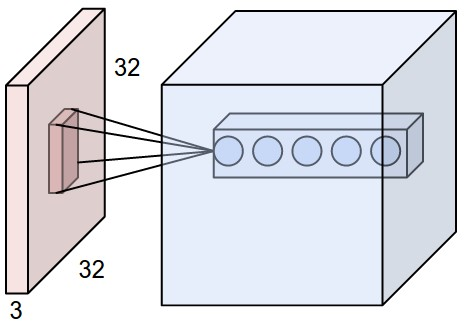
[[2](https://cs231n.github.io/convolutional-networks/)]

There are three hyperparameters that control the output volume of the convolutional layer:
* **Depth** : Number of the filters to use, is the depth of the output volume.
* **Stride** : The stride to slide the filter. E.g. When stride is 1, we move the filters one pixel at a time. Or if we have a stride of 2, the filter jumps 2 pixels at a time as we slide them around, producing a smaller output volume spatially.
* **Padding** : Sometimes it is convenient to pad the input with zeros around the border, where we can set the amount, this again controls the output volume spatial size. Often it is desirable to exactly preserve the spatial size of the input volume.

The spatial size of the output volume can be computed as a function of the input volume size $W$, the kernel (receptive) field size of the convolutional layer neurons $F$, the stride with which they are applied $S$, and the amount of zero padding $P$ used on the border. The formula for calculating how many neurons *\"fit\"* in a given volume is given by

$$ \frac{W - F + 2P}{S} + 1$$

If this number is not an integer, then the strides are incorrect and the neurons cannot be tiled to fit across the input volume in a symmetric way. In general, setting zero padding to be $P=\frac{F-1}{2}$ when the stride is $S=1$ ensures that the input volume and output volume will have the same size spatially. A common setting of the hyperparameters is $F=3,S=1,P=1$.

> Below a convolutional layer demo, all the volumes (the input volume (in blue), the weight volumes (in red), the output volume (in green)) are visualized with each depth slice stacked in rows. The input volume is of size $W_1=5,H_1=5,D_1=3$, and the convolutional layer parameters are $K=2,F=3,S=2,P=1$, where $K$ is the number of filters. Here we have two filters of size $3 \times 3$, and they are applied with a stride of $2$. Therefore, the output volume size has spatial size $\frac{5 - 3 + 2}{2} + 1 = 3$.

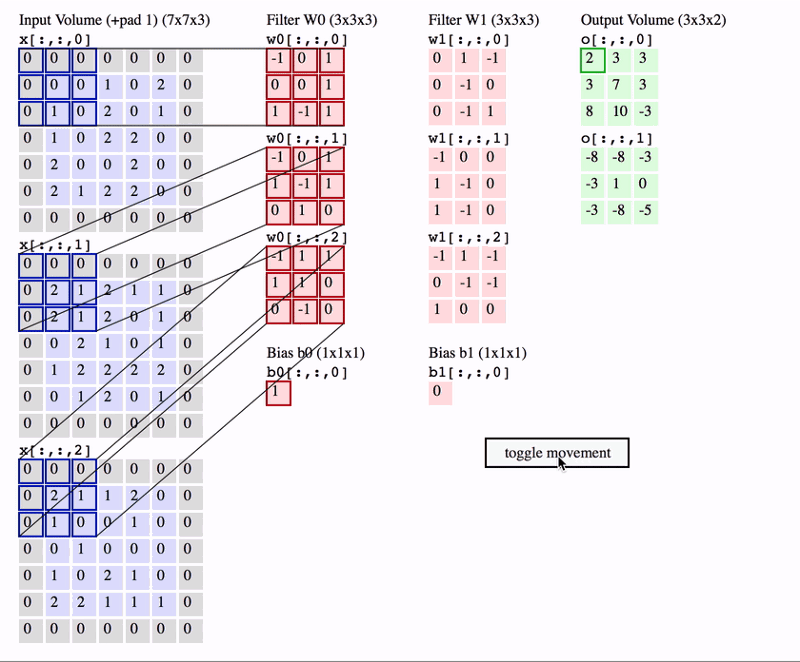
[[3](https://cs231n.github.io/convolutional-networks/)]


## Pooling Layer

Pooling reduces (downsamples) the spatial size, as a form of regularisation. It operates independently on every depth slice of the input and resizes it spatially, using a MAX operator. Commonly the pooling layer is with filters of size $2 \times 2$ applied with a stride of $2$ ($F=2, S=2$), which downsamples every depth slice in the input by $2$ along both width and height, discarding $75\%$ of the activations. In practice another common pooling parameters are $F=3, S=2$ (called overlapping pooling). Max pooling performs the best in practice however there are also other pooling operations such as average pooling or L2-norm pooling.

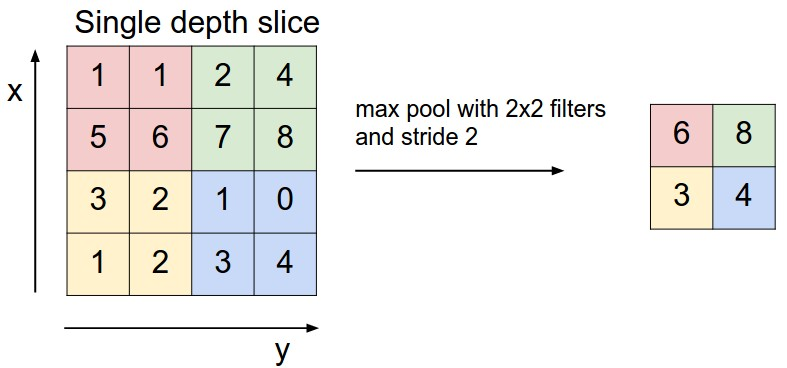
[[4](https://cs231n.github.io/convolutional-networks/)]

> Max pooling with a stride of $2$.

In modern NN architectures it has shown better performance by not using pooling and instead using architectures that only have convolutional layers, and using a larger stride in some layers to reduce the spatial size. This is particularly important for variational autoencoders (VAEs) and generative adversarial networks (GANs).

# ConvNet Architectures

ConvNet architectures are composed of the three simple layers of, Convolutional Layer ($CONV$), Pooling layer ($POOL$) and a Fully Connected layer ($FC$).

## Layer patterns

Most common form of architectures consist of stacking a few convolutional layers, followed by a pool layer, and repeating this until the image has been merged spatially to a small enough size, at which point a fully connected layer would be added. I.e. of the form

$$\left( CONV \times N \mapsto POOL \right) \mapsto FC \times K $$

The pool layers are optional. In practice $ 0 \leq N \geq 3$, $K < 3$. Stacking more $CONV$ layers before every $POOL$ layer can develop more complex features of the input volume before the destructive pooling operation.

In practice it is better to use multiple small filter $CONV$ layers compared to one large filter $CONV$ layer, due to parameter efficiency and allows us to learn more powerful features on the input with fewer parameters.

However this linear list of layers may be outperformed with new architectures such as a residual network. In practice, it is best to look at whatever is best performing on ImageNet a NN classification benchmark, download a pre-trained model and fine tune it onto our data. As training a ConvNet such as Image net can take allot of computational resources.

## Layer sizing patterns

Best practices are to use a input layer that is a power of 2, so that we can easily divide it by 2 as we progress that spatial size through the network. Convolutional layers should be using small filters (e.g. $3 \times 3$ or at most $5 \times 5$), with stride $S=1$, and most importantly padding the input volume with zeros, in the way to not alter the spatial dimensions of the input (i.e. $P=\frac{F-1}{2}$).

Most common pool layers are to use max-pooling with $2\times2$ receptive fields, and a stride of 2.

## Case studies

* VGGNet -  The runner-up in ILSVRC 2014 was the network from Karen Simonyan and Andrew Zisserman that became known as the VGGNet. Its main contribution was in showing that the depth of the network is a critical component for good performance. Their final best network contains 16 CONV/FC layers and, appealingly, features an extremely homogeneous architecture that only performs 3x3 convolutions and 2x2 pooling from the beginning to the end. Their pretrained model is available for plug and play use in Keras `vgg19`.
* ResNet - Residual Network developed by Kaiming He et al. was the winner of ILSVRC 2015. It features special skip connections and a heavy use of batch normalization. The architecture is also missing fully connected layers at the end of the network. Again available in Keras `resnet_v2`

We can look at VGGNet in detail in `Keras`

In [3]:
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
vgg.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

As is common with Convolutional Networks, notice that most of the memory (and also compute time) is used in the early $CONV$ layers, and that most of the parameters are in the last $FC$ layers. In this particular case, the first $FC$ layer contains 100M weights, out of a total of 140M.

# Convolutional Neural Networks in Keras

We introduce the following new layer types 

#### Conv2D

The `tf.keras.layers.Conv2D` layer which takes the specific convolutional keyword arguments:
* `filters`: Integer, the dimensionality of the output space (i.e. the number of output filters in the convolution).
* `kernel_size`: An integer or tuple/list of 2 integers, specifying the height and width of the 2D convolution window (receptive field). Can be a single integer to specify the same value for all spatial dimensions.
* `strides`: An integer or tuple/list of 2 integers, specifying the strides of the convolution along the height and width. Can be a single integer to specify the same value for all spatial dimensions.
* `padding`: One of "valid", or "same" (case-insensitive). "valid" means "no padding". "same" results in padding the input such that the output has the same length as the original input.

#### MaxPooling2D

The `tf.keras.layers.MaxPool2D` layer which takes the following keyword arguments:
* `pool_size`: integer or tuple of 2 integers, factors by which to downscale (vertical, horizontal). (2, 2) will halve the input in both spatial dimension. If only one integer is specified, the same window length will be used for both dimensions.
* `strides`: Integer, tuple of 2 integers, or None. Strides values. If None, it will default to pool_size.
* `padding`: One of "valid" or "same" (case-insensitive).
* `data_format`: A string, one of channels_last (default) or channels_first. The ordering of the dimensions in the inputs. channels_last corresponds to inputs with shape (batch, height, width, channels) while channels_first corresponds to inputs with shape (batch, channels, height, width). It defaults to the image_data_format value found in your Keras config file at ~/.keras/keras.json. If you never set it, then it will be "channels_last".

Lets train our first Convolutional Neural Network on the MNIST (numbers) dataset

In [10]:
from tensorflow import keras

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test),
                    callbacks=[early_stop])


score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 42s 707us/step - loss: 0.2287 - accuracy: 0.9302 - val_loss: 0.0480 - val_accuracy: 0.9849
Epoch 2/12
60000/60000 [==============================] - 37s 623us/step - loss: 0.0798 - accuracy: 0.9763 - val_loss: 0.0355 - val_accuracy: 0.9883
Epoch 3/12
60000/60000 [==============================] - 35s 591us/step - loss: 0.0609 - accuracy: 0.9814 - val_loss: 0.0330 - val_accuracy: 0.9900
Epoch 4/12
60000/60000 [==============================] - 36s 600us/step - loss: 0.0500 - accuracy: 0.9843 - val_loss: 0.0295 - val_accuracy: 0.9909
Epoch 5/12
60000/60000 [==============================] - 37s 615us/step - loss: 0.0397 - accuracy: 0.9880 - val_loss: 0.0267 - val_accuracy: 0.9920
Epoch 6/12
60000/60000 [==============================] - 40s 663us/step - loss: 0.0369 - accuracy: 0.9883 - val_loss: 0.0248 - val_

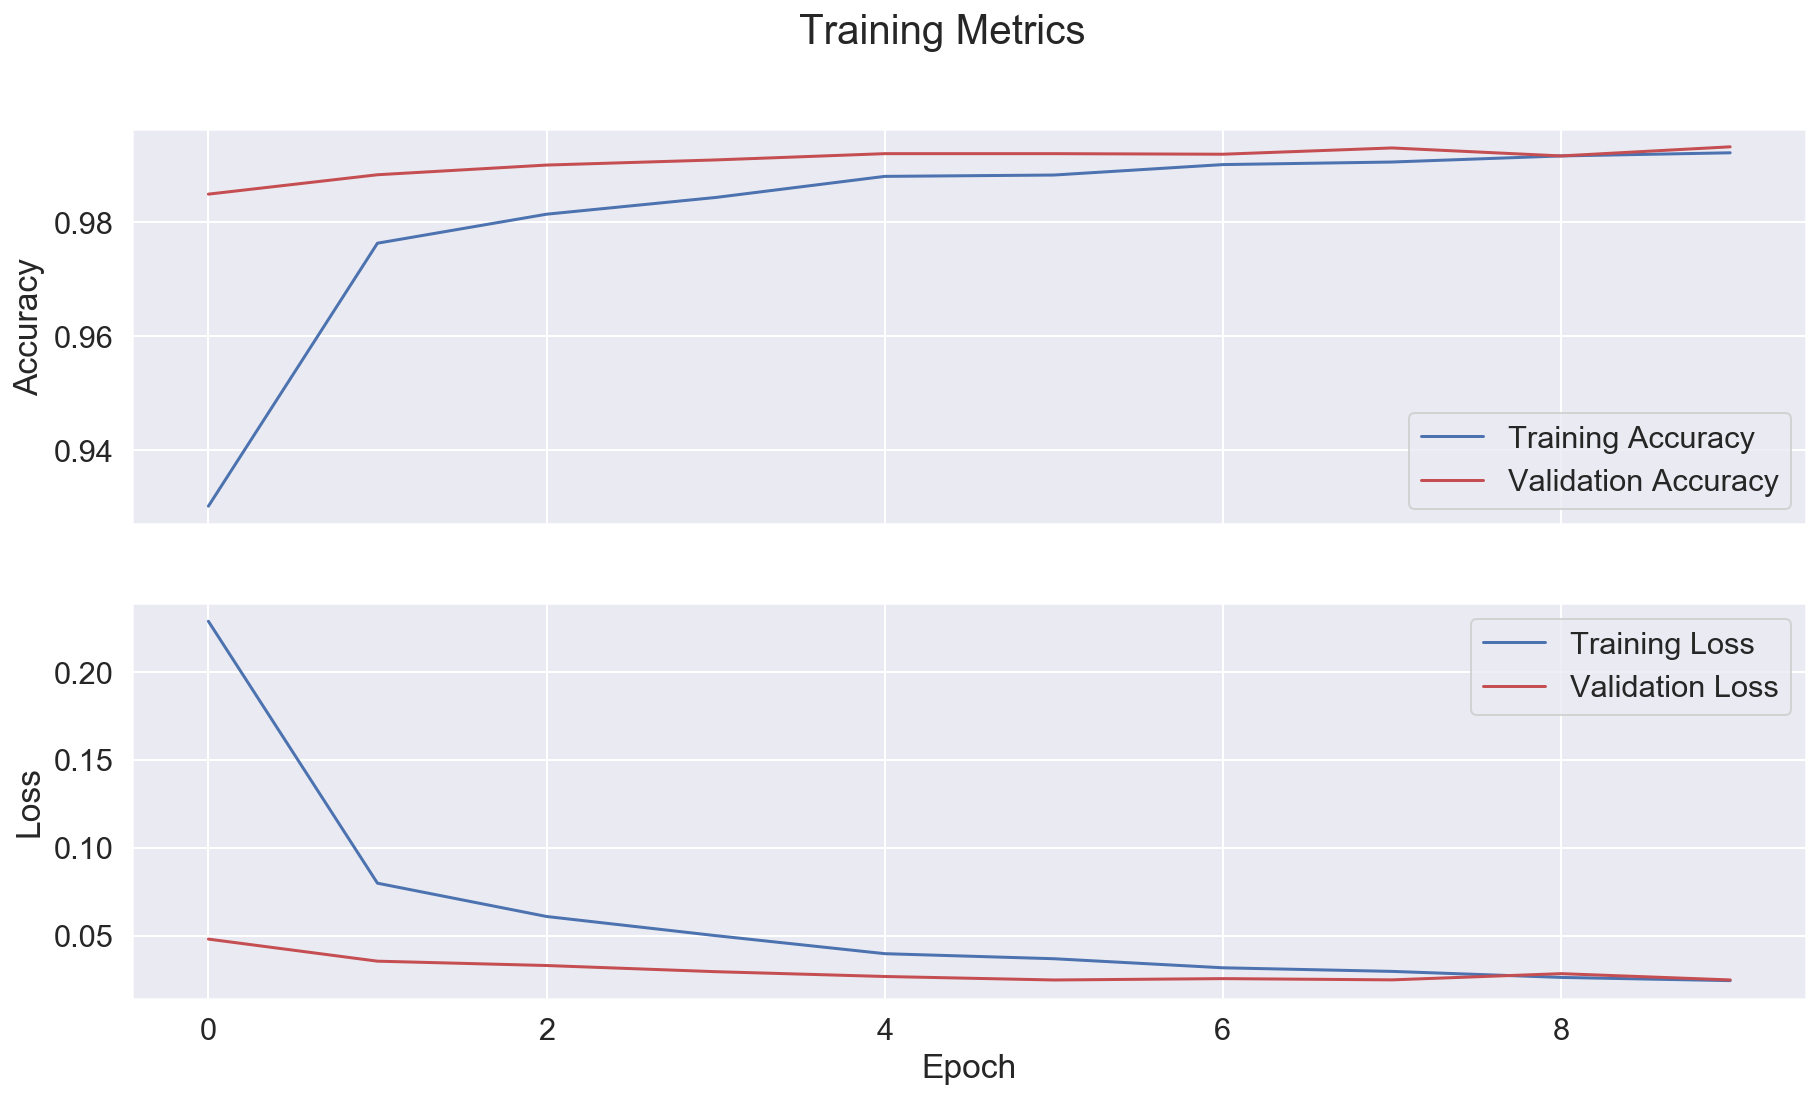

In [15]:
history_df = pd.DataFrame(history.history)
history_df['epoch'] = history.epoch
fig, axes = plt.subplots(2, sharex=True, figsize=(15, 8))
fig.suptitle('Training Metrics')

epochs_to_mean = 1

axes[0].set_ylabel("Accuracy")
axes[0].plot(history_df['accuracy'].rolling(epochs_to_mean).mean(), 'b')
axes[0].plot(history_df['val_accuracy'].rolling(epochs_to_mean).mean(), '-r')
axes[0].legend(['Training Accuracy', 'Validation Accuracy'])

axes[1].set_ylabel("Loss")
axes[1].plot(history_df['loss'].rolling(epochs_to_mean).mean(), 'b')
axes[1].plot(history_df['val_loss'].rolling(epochs_to_mean).mean(), '-r')
axes[1].legend(['Training Loss', 'Validation Loss'])
axes[1].set_xlabel("Epoch")

plt.show()